# Tutorial 3: Multi-sample integration (STARmap)

Here, we validated the capability of our multi-sample integration model, GraphPCA_multi, a multi-sample extension of GraphPCA through aggregating multiple spatial neighborhood graphs and expression profiles into one matrix.

To achieve it, besides the BZ5 sample used in tutorial2, we obtained two additional tissue sections BZ9 and BZ14 generated by STARmap from different mice. Cells in all sections are annotated into four cortical layers (L1, L2/3, L5 and L6) according to [the original publication](https://www.science.org/doi/10.1126/science.aat5691).

## Load packages

In [1]:
import GraphPCA as sg
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.neighbors import kneighbors_graph

## Load data

In [2]:
slice_inds = np.arange(0,3)
samples = ["BZ5","BZ9","BZ14"]
data_path = "../../data/STARmap/"
save_path = "../../results/STARmap/"
PCA_components = 50

In [3]:
Batch_list = []
adj_list = []


for sample_id in slice_inds:
    print(samples[sample_id])
    
    STARmap_expr = pd.read_csv(data_path + "STARmap_expr_" + samples[sample_id] + ".csv",index_col=0).T
    STARmap_loc = pd.read_csv(data_path + "STARmap_loc_" + samples[sample_id] + ".csv",index_col=0)
    groundTruth = pd.read_csv(data_path + "STARmap_groundtruth_" + samples[sample_id] + ".csv",index_col=0)["z"].astype("category")
    adata = ad.AnnData(STARmap_expr)
    adata.obs = STARmap_loc.copy()
    adata.uns["spatial"] = np.array(STARmap_loc)

    adata.obs["groundtruth"] =np.array(groundTruth)-1
    adata.obs["groundtruth"] = adata.obs["groundtruth"].astype(int).astype("category")

    adata.var_names_make_unique()  
    
    # make spot name unique
    adata.obs_names = [x+'_'+ samples[sample_id] for x in adata.obs_names]

    
    ## Constructing the spatial network
    x_array=adata.obs["x"].tolist()
    y_array=adata.obs["y"].tolist()
    location=np.array([x_array, y_array]).T.astype(np.float32)
    n_neighbors = 7
    graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
    adata.obsm["spatial"] = location
    
    # Normalization
    sc.pp.filter_genes(adata, min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

BZ5
BZ9
BZ14


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=samples[slice_inds[0]:slice_inds[-1]+1])
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3190, 159)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(samples[slice_inds[0]:slice_inds[-1]+1])):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat.uns['network'] = scipy.sparse.csr_matrix(adj_concat)

In [6]:
adata_concat

AnnData object with n_obs × n_vars = 3190 × 159
    obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name'
    uns: 'edgeList', 'network'
    obsm: 'spatial'

## Perform GraphPCA_multi

In [7]:
Z,_ = sg.Run_GPCA(adata_concat, network=adata_concat.uns['network'], n_components = 50, method = "knn", _lambda = 0.6,n_neighbors=7,
               save_reconstruction=True)
adata_concat.obsm["GraphPCA"] = Z
print(Z.shape)

(3190, 50)


## Clustering

In [8]:
estimator = KMeans(n_clusters=4)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata_concat.obs["GPCA_pred"]= lable_pred
adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
adata_concat.obsm["GraphPCA"] = Z
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.7636451157316565


## Visualization

In [9]:
adata_concat.obs['GPCA_pred'] = pd.Series(sg.match_cluster_labels(adata_concat.obs['groundtruth'], adata_concat.obs['GPCA_pred'].values),
                                         index=adata_concat.obs.index, dtype='category')

In [10]:
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

for bb in range(3):

    refined_pred=sg.refine(sample_id=Batch_list[bb].obs.index.tolist(), pred=Batch_list[bb].obs["GPCA_pred"].tolist(),
                        dis= pair(Batch_list[bb].obsm["spatial"]), shape="generic",neighbor_num=7)
    Batch_list[bb].obs["GPCA_pred"] = refined_pred
    Batch_list[bb].obs["GPCA_pred"] = Batch_list[bb].obs["GPCA_pred"].astype('category')



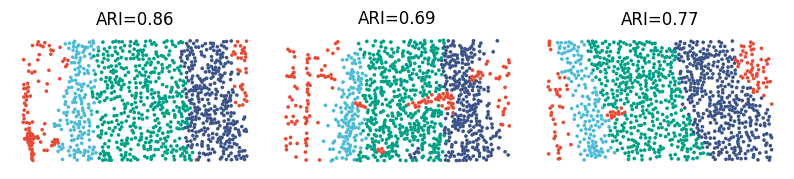

In [11]:
import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
Ref_colors = ["#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF"]
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()